# 画像の二値化：グレースケール画像から二値画像への変換

みなさんも、文書をスキャンして保存したことがあると思います。   
スキャナは、紙面にライン状の光を移動させながら当てて、跳ね返ってきた光（白い部分はたくさん跳ね返り、黒い部分はあまり跳ね返らない）の光量を撮像素子で測定する装置です。   
いわば、紙面をカメラで撮影するようなものですね。   
ですから、撮影された時点では、その画像は複数の階調を持つグレースケール画像です。   
しかし、その紙面が文字のみで構成された文書の場合は、文字部分が黒、背景部分が白、の白か黒かしかないので、
その中間色（灰色）は本来は不要で、目ざわりなノイズとなってしまいます。   
そこで、スキャナでは、そのようなグレースケール画像に対し、画像処理で二値画像に変換します。

商品として売られている商品では、いくつかの二値化アルゴリズムが組み合わされていますが、
ここでは基本的なアルゴリズムである閾値処理で二値化する手法について学びましょう。


## 閾値処理による二値化

閾値処理とは、グレースケール画像の各画素に対して、その濃淡値があらかじめ定めた定数（これを閾値とよぶ）以上のときその画素を白、閾値以下のときその画素を黒とするものです。   

### 例題：画像の読み込み

裏紙に手書きで文字を書いた用紙をスキャンした場合を考えましょう。   
背景部分は真っ白ではなく、うっすらと裏の文字が透けて見えています。

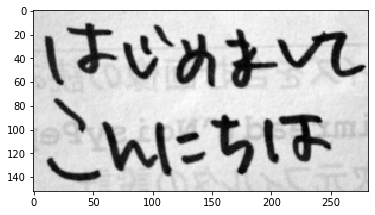

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

# 手書き文字のスキャン画像（グレースケール）
img_gray = cv2.imread('img/handWriteAIUEO.png', cv2.IMREAD_ANYDEPTH) 
plt.imshow(img_gray, 'gray')


### 閾値処理

画像の閾値処理には`opencv`の`cv2.threshold`という関数を利用します。   
8-bit画像の濃淡値の範囲（0-255)の中央値は127ですから、とりあえず127を閾値として、白と黒に分けて見ましょう。   
どうなるでしょうか？

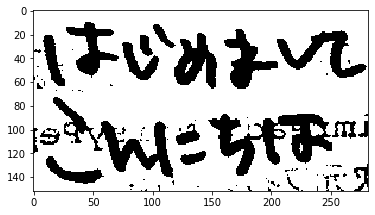

True

In [8]:
th = 127 # 輝度値の中心は127です。もしこの値で白と黒に分けてしまうとどうなるでしょうか？
ret,th_img = cv2.threshold(img_gray, th, 255, cv2.THRESH_BINARY)
plt.imshow(th_img,'gray')
plt.show()
cv2.imwrite('img/th_img.png', th_img)

裏書の文字が透けて見えてしまっているようです。   
閾値は、スキャン対象の紙面の状態によって調節する必要がありそうです。   
適切な閾値を決めるために、この画像のヒストグラムを計算しましょう。

### 画像のヒストグラム

Python入門の授業では、文字n-gramのヒストグラムという概念が出てきましたね。   
あの課題では、ある特定の文字n-gramが文書全体に何回出てくるかを数えたものでした。   
あのようなヒストグラムという概念はいろいろな分野で現れて、画像でもヒストグラムがあります。   
画像のヒストグラムとは、x軸が濃淡値で、y軸はその濃淡値を持つ画素が画像中にいくつあるかをグラフ化したものです。  　
ここで、x軸におけるメモリの細かさは必ずしも濃淡差1ではなく、ある程度幅を設ける（たとえば256階調のグレースケールを16段階に分けるとすると、濃淡値が0～15までの画素の数、濃淡値が16～31までの画素の数、と数えていくこと）のが普通です。  
このとき、この幅の一つ一つをビン(bin)と呼びます（先ほどの例では16個のビンに分けることになります）。   
opencvで画像のヒストグラムを計算して描画する関数は、   
```cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]])```   
です。この時、histSizeがビンの数を意味します。


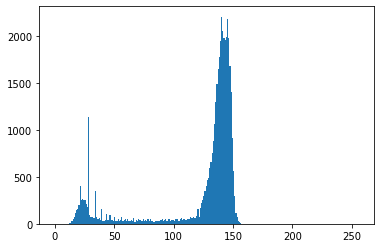

In [11]:
plt.hist(img_gray.ravel(),256,[0,256])
#plt.hist(img_gray.ravel(),64,[0,256]) # ビンの数を64個（つまり輝度の幅を4にする）とどうなるでしょうか？
plt.show()


このヒストグラムを見ると、山が二つあるのが分かります。   
このうち、0に近いほうが文字の画素、1に近いほうが背景の画素であると予想されます。   
それを白と黒に分けたいなら、閾値を80くらいに設定すればいいということがわかります。


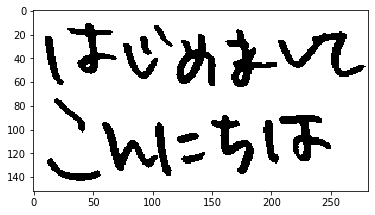

In [12]:
th = 80 # 閾値
ret,th_img2 = cv2.threshold(img_gray,th,255,cv2.THRESH_BINARY)
plt.imshow(th_img2,'gray')
plt.show()

### 大津の二値化

ヒストグラムを見れば、適切な閾値を決めることはできそうですが、毎回人が見て閾値を決めるのは面倒ですよね。   
そこで、適切な閾値を決める方法がいろいろと考えられました。   
この中で、大津の二値化は、文書をスキャンした画像はヒストグラムは上に示したように二つの山になるという前提のもと、
閾値で二つのクラスに分けたとき、各クラス内の画素間ではそれらの濃淡値の分散が小さくなり、違うクラスどうしの画素間ではそれらの濃淡値の分散が大きくなるような閾値を見つける手法です。

ちなみにこの手法を提案された大津展之先生は東大の卒業生ですね。   
[Nobuyuki Otsu, "A threshold selection method from gray-level histograms", IEEE Transactions on Systems, Man, and Cybernetics, 1979](https://engineering.purdue.edu/kak/computervision/ECE661.08/OTSU_paper.pdf)

計算された閾値: 87.0


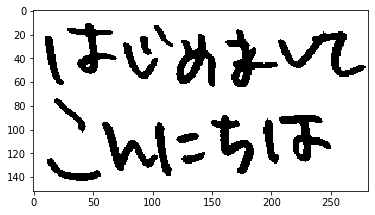

True

In [16]:
ret2,th_img3 = cv2.threshold(img_gray,0,255,cv2.THRESH_OTSU)

print('計算された閾値:', ret2)
plt.imshow(th_img3,'gray')
plt.show()
cv2.imwrite('img/otsu.png', th_img3)